# Import Necessary Packages

In [1]:
from IPython.display import display, Markdown, clear_output
import ipywidgets as widgets
import numpy as np
import tensorflow as tf
import cv2 
import os
from tensorflow.keras import layers
from scipy.interpolate import splprep, splev
from tensorflow import keras
keras.backend.set_image_data_format('channels_last')
import pandas as pd
import numpy
from pathlib import Path
from scipy.spatial import distance
import math
import sys
from scipy.ndimage import gaussian_filter
from random import choice
import time
import panel as pn
pn.extension()
from tensorflow.keras.models import Model, Sequential, load_model

%load_ext autotime

from imutils import perspective
from scipy.spatial import distance as dist
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image
from scipy.spatial import distance



time: 175 ms (started: 2022-07-03 21:18:51 +00:00)


# Load function for pre and post processing

In [3]:
def remove_text_file(image_file_name):
    image = cv2.imread('web_data/'+ image_file_name)
    
    text = np.zeros((image.shape[0],16,image.shape[2]),dtype = np.int32)
    text[:,8:16,:] = 1
    maximum = -999
    index = 0
    for i in range(image.shape[1]-16):
        result = np.sum(text*image[:,i:i+16,:])
        if (result>maximum):
            maximum = result
            index = i
        
    if(index < 50):
        image_after_text = image[:,0:image.shape[1]-200,:]
    else:
        image_after_text = image[:,0:index+8,:]
    cv2.imwrite('web_data/' +'without_text_'+image_file_name, image_after_text)
    return 'without_text_'+ image_file_name


def find_start_position(image,point):
    for n in range(point[0], image.shape[1]):
        max_value = 0.
        max_value_index= 0
        for m in range(point[1],image.shape[0]):
             if image[m,n] > max_value:
                max_value = image[m,n]
                max_value_index= m
        if(max_value>0):
            break
    start = (n,max_value_index)
    return start



def find_continuous_line(image, point):
    points_list=[]
    points_list.append(point)
    
    while(1):
        
        current_x = points_list[-1][0]
        current_y = points_list[-1][1]
        
        if current_x+1>image.shape[1]-1:
            break
        if current_y-1<0:
            break
        if current_y+1>image.shape[0]-1:
            break
        
        value = []
        value = (image[current_y+1, current_x+1],
                     image[current_y, current_x+1],
                     image[current_y-1, current_x+1])
        
        maximum = max(value)
        if maximum==0:
            break
        else:
            if (image[current_y+1, current_x+1]==maximum):
                points_list.append((current_x+1, current_y+1))
            elif (image[current_y, current_x+1]==maximum):
                points_list.append((current_x+1, current_y))
            else:
                points_list.append((current_x+1, current_y-1))
                
    return points_list[1:]

def find_continuous_line_for_tooth_bone_area(image, point):
    points_list=[]
    points_list.append(point)
    
    
    while(1):
        current_x = points_list[-1][0]
        current_y = points_list[-1][1]
        
        if current_x+1>image.shape[1]-1:
            break
            
        value = image[:, current_x+1]
        maximum = max(value)
        if maximum==0:
            break
        else:
            current_y = np.nonzero(value)
            points_list.append((current_x+1, current_y[0][0]))
    return points_list[1:]


def findIntersection(x1,y1,x2,y2,x3,y3,x4,y4):
        px= ( (x1*y2-y1*x2)*(x3-x4)-(x1-x2)*(x3*y4-y3*x4) ) / ( (x1-x2)*(y3-y4)-(y1-y2)*(x3-x4) ) 
        py= ( (x1*y2-y1*x2)*(y3-y4)-(y1-y2)*(x3*y4-y3*x4) ) / ( (x1-x2)*(y3-y4)-(y1-y2)*(x3-x4) )
        return (int(px), int(py))

    
def show_mask(mask):
    visible_mask = np.zeros((mask.shape[0],mask.shape[1]), dtype = np.uint8)
    for i in range (mask.shape[0]):
        for j in range(mask.shape[1]):
            if(mask[i,j]==1):
                visible_mask[i,j] = 255
    return visible_mask

time: 1.97 ms (started: 2022-07-03 21:06:37 +00:00)


# Load model weights for bone area, tooth and CEJ line Masks

In [4]:
pretrianed_bone_area_model = keras.models.load_model('models/model_for_bone_area_resnet_34.h5')
pretrianed_tooth_model = keras.models.load_model('models/model_for_tooth_resnet_34_512.h5')
pretrianed_cej_line_model = keras.models.load_model('models/model_for_cej.h5')

time: 17.4 s (started: 2022-07-03 21:06:39 +00:00)


# Bone Area Prediction

In [9]:
def bone_area_prediction(image_file_name):
    
    image = cv2.imread('sample_images/peri_images/'+ image_file_name)
    
    IMG_HEIGHT = 128
    IMG_WIDTH = 128
    IMG_CHANNELS = 3
    X_test = np.zeros((1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    
    img = cv2.applyColorMap(image, cv2.COLORMAP_JET)
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    X_test[0] = img
    prediction_for_test = pretrianed_bone_area_model.predict(X_test, verbose=1)
    temp = prediction_for_test[0,:,:,0]
    cv2.imwrite('test.png',temp)
    img_y = cv2.imread('test.png',0)
    img_y = show_mask(img_y)
    img_y = cv2.resize(img_y,(image.shape[1],image.shape[0]))
    img = cv2.GaussianBlur(img_y,(5,5),1)
    ret,thresh = cv2.threshold(img,127,255,0)
    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

    contoursSorted = sorted(contours, key=lambda x: cv2.contourArea(x), reverse = True)
    img_color = np.zeros((image.shape[0], image.shape[1], 3))
      
    smoothened = []
    
    for c in contoursSorted:
        #if (cv2.contourArea(c)>5000):
        if (cv2.contourArea(c)>40000):
            x,y = c.T
            x = x.tolist()[0]
            y = y.tolist()[0]
            tck, u = splprep([x,y], u=None, s=1.0, per=1)
            u_new = numpy.linspace(u.min(), u.max(), 70)
            x_new, y_new = splev(u_new, tck, der=0)
            res_array = [[[int(i[0]), int(i[1])]] for i in zip(x_new,y_new)]
            smoothened.append(numpy.asarray(res_array, dtype=numpy.int32))
            cv2.fillPoly(img_color,smoothened,color = (255,255,255))
    cv2.imwrite('sample_images/masks/'+ 'bone_area_'+image_file_name, img_color)

time: 1.31 ms (started: 2022-07-03 21:07:37 +00:00)


# Tooth Prediction

In [10]:
def tooth_prediction(image_file_name):
    
    image = cv2.imread('sample_images/peri_images/'+ image_file_name)
    
    IMG_HEIGHT = 512
    IMG_WIDTH = 512
    IMG_CHANNELS = 3
    X_test = np.zeros((1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    
    img = cv2.applyColorMap(image, cv2.COLORMAP_JET)
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    X_test[0] = img
    prediction_for_test = pretrianed_tooth_model.predict(X_test, verbose=1)
    temp = prediction_for_test[0,:,:,0]
    
    cv2.imwrite('test.png',temp)
    img_y = cv2.imread('test.png',0)
    
    img_y = show_mask(img_y)
    img_y = cv2.resize(img_y,(image.shape[1],image.shape[0]))
    img = cv2.GaussianBlur(img_y,(5,5),1)
    ret,thresh = cv2.threshold(img,127,255,0)

    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    contoursSorted = sorted(contours, key=lambda x: cv2.contourArea(x), reverse = True)
    img_color = np.zeros((image.shape[0], image.shape[1], 3))

        
    smoothened = []
    
    for c in contoursSorted:
        if (cv2.contourArea(c)>5000):
            x,y = c.T
            x = x.tolist()[0]
            y = y.tolist()[0]
            tck, u = splprep([x,y], u=None, s=1.0, per=1)
            u_new = numpy.linspace(u.min(), u.max(), 70)
            x_new, y_new = splev(u_new, tck, der=0)
            res_array = [[[int(i[0]), int(i[1])]] for i in zip(x_new,y_new)]
            smoothened.append(numpy.asarray(res_array, dtype=numpy.int32))
            cv2.fillPoly(img_color,smoothened,color = (255,255,255))
    cv2.imwrite('sample_images/masks/'+ 'tooth_'+ image_file_name, img_color)

time: 1.18 ms (started: 2022-07-03 21:07:39 +00:00)


# CEJ line Predicion

In [11]:
def cej_line_prediction(image_file_name):
    
    image = cv2.imread('sample_images/peri_images/'+ image_file_name)
    
    IMG_HEIGHT =128
    IMG_WIDTH =128
    IMG_CHANNELS = 3

    X_test = np.zeros((1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

    img = cv2.applyColorMap(image, cv2.COLORMAP_JET)
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    X_test[0] = img
    prediction_for_test = pretrianed_cej_line_model.predict(X_test, verbose=1)
    temp = prediction_for_test[0,:,:,0]
    cv2.imwrite('test.png',temp)
    img_y = cv2.imread('test.png',0)
    img_y = show_mask(img_y)
    img_y = cv2.resize(img_y,(image.shape[1],image.shape[0]))
    img = img_y
    
    img_binary = np.zeros((img.shape[0], img.shape[1]))
    for p in range(img.shape[0]):
        for q in range(img.shape[1]):
            if(img[p,q] > 128):
                img_binary[p,q] = 255
               
    kernel = np.ones((7,7),np.uint8)
    img_binary = gaussian_filter(img_binary, sigma=(7,7))
    img_binary = cv2.dilate(img_binary,kernel,iterations = 1)
    img_binary = cv2.erode(img_binary,kernel,iterations = 1)

    img_filter = np.zeros((img.shape[0], img.shape[1]))
    for m in range(img.shape[0]-2):
        for n in range(img.shape[1]-2):
            img_filter[m+1,n+1] = np.sum(img_binary[m:m+3,n:n+3])
            
    segments = []
    segments_debug = []
    initial = (0,0)
    while initial[0] < img_filter.shape[1]:
        start_line = find_start_position(img_filter,initial)
        all_points = []
        all_points.append(start_line)
        continuous_points = find_continuous_line(img_filter, start_line)
        all_points.extend(continuous_points)

        segments_debug.append(all_points)
        segments.extend(all_points)
        last_point = all_points[-1]
        initial = (last_point[0]+1, max(last_point[1]-50, 0))
    
    img_draw = np.zeros((img.shape[0], img.shape[1],3))
    for pp in range(len(segments)-2):
        cv2.line(img_draw,(segments[pp][0],segments[pp][1]),(segments[pp+1][0],segments[pp+1][1]),(255,255,255),1)
    
    cv2.imwrite('sample_images/masks/'+ 'cej_line_'+ image_file_name, img_draw)

time: 1.38 ms (started: 2022-07-03 21:07:41 +00:00)


# Display Sample Image and corresponding bone area, tooth and CEJ line Masks

In [12]:
image_file_name = 'sample_1.png'
image = cv2.imread('sample_images/peri_images/'+ image_file_name)

bone_area_prediction(image_file_name)
tooth_prediction(image_file_name)
cej_line_prediction(image_file_name)




1/1 [==============================] - 1s 1s/step


/usr/local/lib/python3.8/dist-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][1471]=x[0][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %


1/1 [==============================] - 0s 429ms/step
time: 7.72 s (started: 2022-07-03 21:07:44 +00:00)


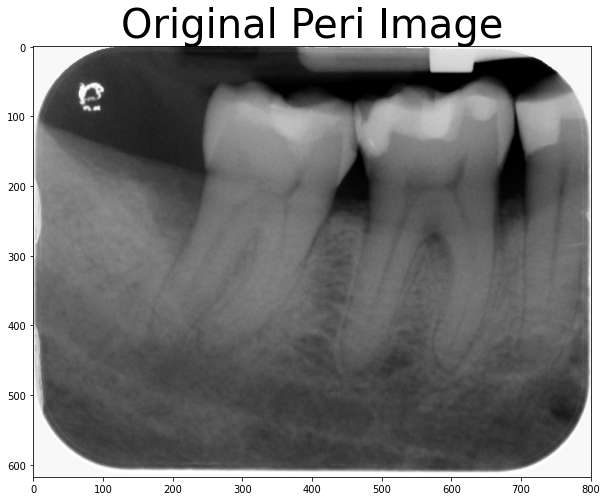

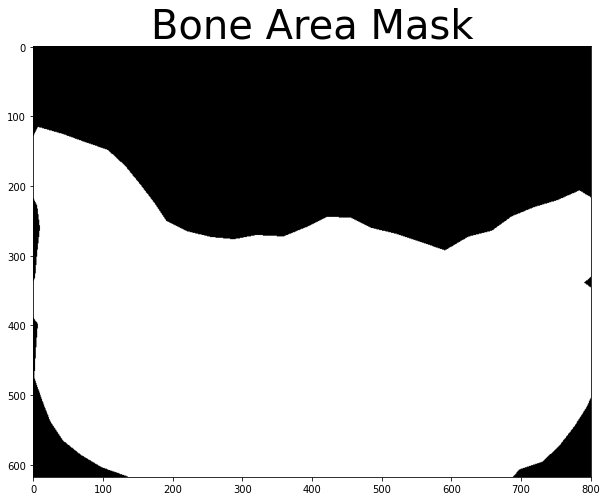

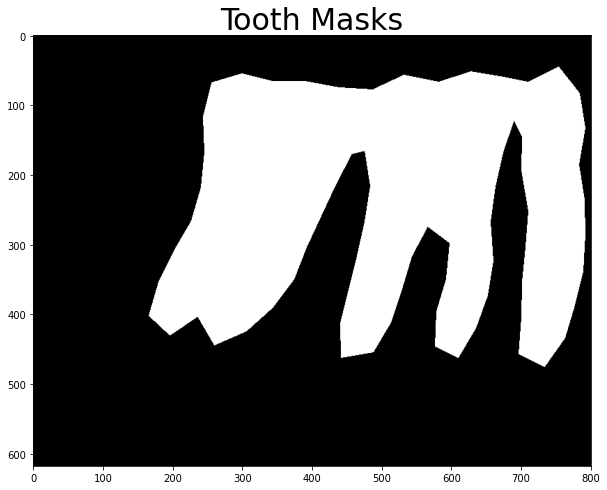

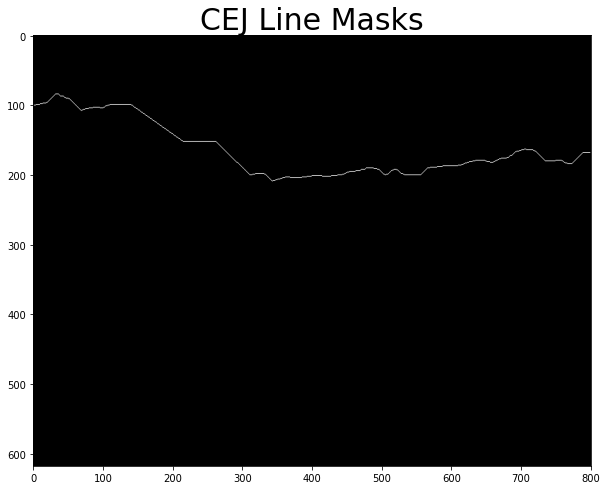

time: 976 ms (started: 2022-07-03 21:19:37 +00:00)


In [3]:
image_file_name = 'sample_1.png'
image = cv2.imread('sample_images/peri_images/'+ image_file_name)
bone_area_masks = cv2.imread('sample_images/masks/'+ 'bone_area_'+  image_file_name)
tooth_masks = cv2.imread('sample_images/masks/'+ 'tooth_'+  image_file_name)
cej_masks = cv2.imread('sample_images/masks/'+ 'cej_line_'+  image_file_name)


plt.figure(figsize = (10,10))
plt.title("Original Peri Image",fontsize = 40)
plt.imshow(image, cmap= 'gray')

plt.figure(figsize = (10,10))
plt.title("Bone Area Mask",fontsize = 40)
plt.imshow(bone_area_masks, cmap= 'gray')

plt.figure(figsize = (10,10))
plt.title("Tooth Masks",fontsize = 30)
plt.imshow(tooth_masks, cmap= 'gray')


plt.figure(figsize = (10,10))
plt.title("CEJ Line Masks",fontsize = 30)
plt.imshow(cej_masks, cmap= 'gray')




